In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [2]:
import iris
import iris.quickplot as qplt

## First open data in Iris for regridding

In [3]:
cpm_cubes = iris.load("../../../data/2.2km/rcp85/01/pr/*.nc")
gcm_cubes = iris.load("../../../data/60km/rcp85/01/*/day/*.nc")

In [4]:
cpm_cubes

Lwe Precipitation Rate (mm/day),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [5]:
gcm_cubes

Air Pressure At Sea Level (hPa),ensemble_member,time,projection_y_coordinate,projection_x_coordinate
Shape,1,3600,23,17
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
projection_y_coordinate,-,-,x,-
projection_x_coordinate,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [6]:
cpm_cubes[0]

Lwe Precipitation Rate (mm/day),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


GCM and CPM data use different coordinate systems. GCM is on the OSGB projection, while CPM is on a rotated pole system.

In [11]:
gcm_cubes[2].coord_system()

TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))

In [8]:
cpm_cubes[0].coord_system()

RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))

## Re-grid GCM data 
So that it uses the same co-ordinate system AND have a simple way to match the GCM values to the CPM values (have same co-ordinates).

NB this is not particularly fast on this laptop and is quite memory intensive - turns a small 60km dataset set into a much large 2.2km dataset but without any actually added data. Could look to do this on the fly instead.
Iris will make a lazy cube so then re-processes it each time of asking (slow!). For time being saving the output to disk. Also I prefer working with xarray so this approach allows it.

In [100]:
rp_gcm_cube = gcm_cubes[2].regrid(cpm_cubes[0], iris.analysis.Nearest())
iris.save(rp_gcm_cube, '../../../derived_data/60km/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_rp_regrid_19791201-19891130.nc')

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


In [15]:
iris.save(gcm_cubes[0].regrid(cpm_cubes[0], iris.analysis.Nearest()), '../../../derived_data/60km/rcp85/01/psl/day/psl_rcp85_land-gcm_uk_60km_01_day_rp_regrid_19791201-19891130.nc')

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


In [18]:
gcm_cubes[0].coords()

[DimCoord(array([1], dtype=int32), standard_name=None, units=Unit('1'), long_name='ensemble_member', var_name='ensemble_member'),
 DimCoord(array([ 85692.,  85716.,  85740., ..., 172020., 172044., 172068.]), bounds=array([[ 85680.,  85704.],
        [ 85704.,  85728.],
        [ 85728.,  85752.],
        ...,
        [172008., 172032.],
        [172032., 172056.],
        [172056., 172080.]]), standard_name='time', units=Unit('hours since 1970-01-01 00:00:00', calendar='360_day'), var_name='time'),
 DimCoord(array([ -90000.,  -30000.,   30000.,   90000.,  150000.,  210000.,
         270000.,  330000.,  390000.,  450000.,  510000.,  570000.,
         630000.,  690000.,  750000.,  810000.,  870000.,  930000.,
         990000., 1050000., 1110000., 1170000., 1230000.]), bounds=array([[-120000.,  -60000.],
        [ -60000.,       0.],
        [      0.,   60000.],
        [  60000.,  120000.],
        [ 120000.,  180000.],
        [ 180000.,  240000.],
        [ 240000.,  300000.],
       

### CPM pr for 1st Dec 1980

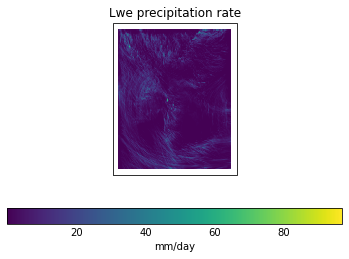

In [87]:
qplt.pcolormesh(cpm_cubes[0].extract(iris.Constraint(ensemble_member=1))[0])

### GCM pr for 1st Dec 1980

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


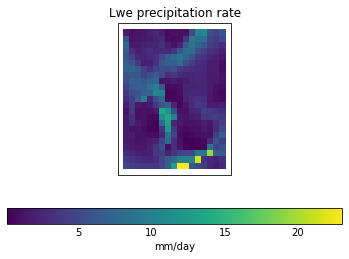

In [125]:
qplt.pcolormesh(gcm_cubes[2].extract(iris.Constraint(ensemble_member=1))[360])

### Re-gridded GCM pr for 1st Dec 1980

In [ ]:
qplt.pcolormesh(rp_gcm_cube.extract(iris.Constraint(ensemble_member=1))[360])

## Re-open datasets in xarray

Mainly because that's what I prefer to work with!

In [25]:
pr = xr.open_mfdataset("../../../data/2.2km/rcp85/01/pr/*.nc")
gcmdata = xr.open_mfdataset("../../../data/60km/rcp85/01/*/day/*.nc")
regridded_gcmdata = xr.open_dataset('../../../derived_data/60km/rcp85/01/pr/day/pr_rcp85_land-gcm_uk_60km_01_day_rp_regrid_19791201-19891130.nc')

In [26]:
pr_single_day = pr.sel(ensemble_member=1, time=cftime.Datetime360Day(1980, 12, 1, 12, 0, 0, 0))
gcm_single_day = gcmdata.sel(ensemble_member=1, time=cftime.Datetime360Day(1980, 12, 1, 12, 0, 0, 0))

In [27]:
regridded_gcmdata

<xarray.Dataset>
Dimensions:                     (bnds: 2, ensemble_member: 1, grid_latitude: 606, grid_longitude: 484, time: 3600)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1979-12-01 12:00:00 ... 1989-11...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          (ensemble_member) |S27 ...
    month_number                (time) int32 ...
    year                        (time) int32 ...
    yyyymmdd                    (time) |S64 ...
Dimensions without coordinates: bnds
Data variables:
    pr                          (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float64 ...
    grid_longitude_bnds         (grid_longitude, bnds) float64 ...
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [30]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

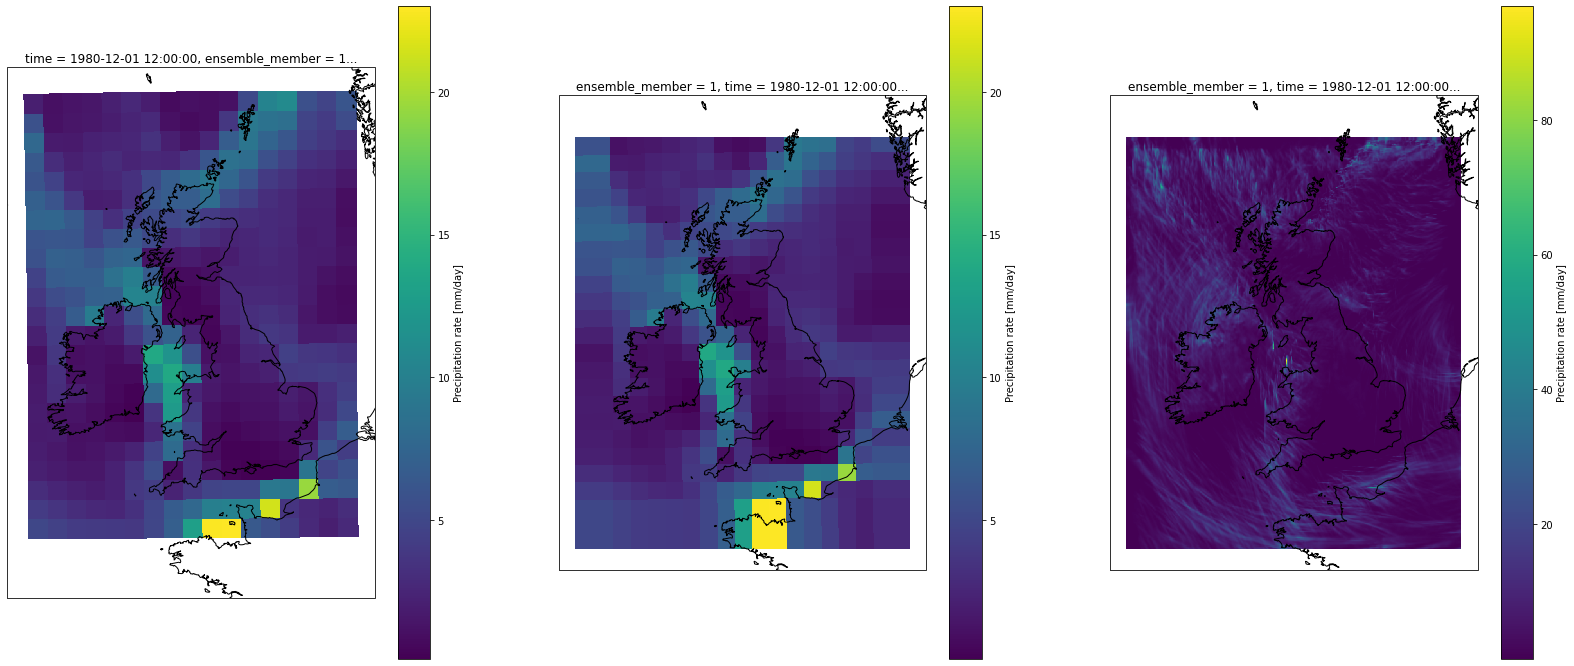

In [134]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(28, 12), sharey=True, subplot_kw={'projection': cp_model_rotated_pole})

gcm_single_day.pr.plot(ax=ax1, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)
regridded_gcmdata.isel(ensemble_member=0, time=360).pr.plot(ax=ax2, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
pr_single_day.pr.plot.pcolormesh(ax=ax3, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

## Selecting and assigning to subsets

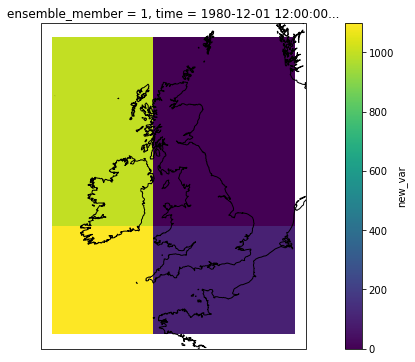

In [128]:
pr_single_day['new_var'] = xr.full_like(pr_single_day.pr, fill_value=0)
pr_single_day['new_var'] = xr.where(pr_single_day['new_var'].coords["grid_latitude"] < 0, 100, pr_single_day["new_var"])
pr_single_day['new_var'][dict(grid_longitude=slice(200))] += 1000

plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(pr_single_day['new_var'], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


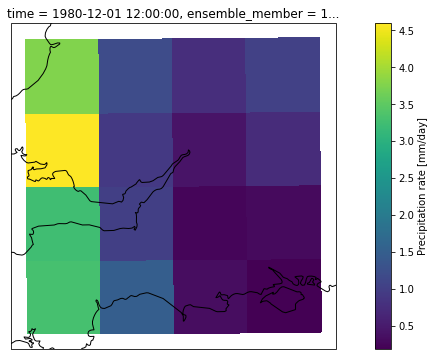

In [178]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
                       
da = gcm_single_day.pr[3:7, 8:12]
xplt.plot(da, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)

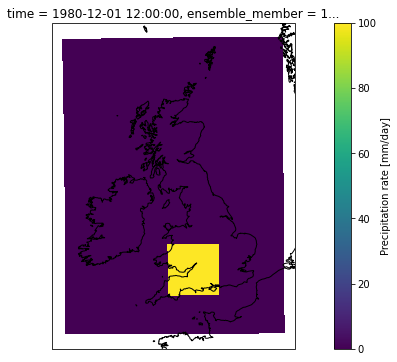

In [171]:
gcm_single_day['new_var'] = xr.full_like(gcm_single_day.pr, fill_value=0)
gcm_single_day['new_var'][3:7, 8:12] = 100

plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(gcm_single_day['new_var'], x='longitude', y='latitude', add_colorbar=True, transform=platecarree)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


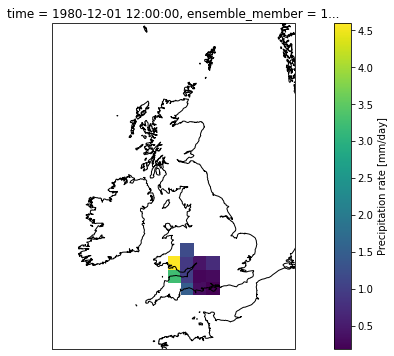

In [194]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
mask = (
    (gcm_single_day.latitude < 52.3276151188887) & (gcm_single_day.latitude > 50.694524325907075) &
    (gcm_single_day.longitude < -1.2662661736262122) & (gcm_single_day.longitude > -3.9072194147630217)
)
da = gcm_single_day.where(mask).pr
                       

xplt.plot(da, x='longitude', y='latitude', add_colorbar=True, transform=platecarree)

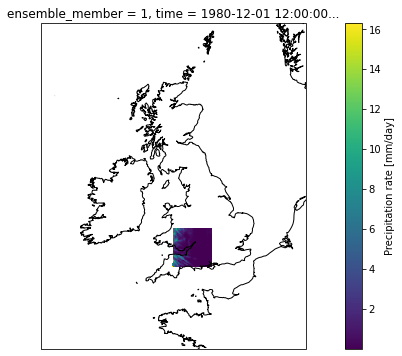

In [193]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()
mask = (
    (pr_single_day.latitude < 52.3276151188887) & (pr_single_day.latitude > 50.694524325907075) &
    (pr_single_day.longitude < -1.2662661736262122) & (pr_single_day.longitude > -3.9072194147630217)
)
da = pr_single_day.where(mask).pr
                       

xplt.plot(da, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)